# ENGR 520 Homework 2 Exercise 2-2

In [1]:
import numpy as np
from numpy.typing import ArrayLike
from matplotlib.figure import Figure
from matplotlib.axes import Axes
import matplotlib.pyplot as plt
import torch
from tqdm import trange
from scipy.interpolate import LinearNDInterpolator, RegularGridInterpolator

In [2]:
# Use CUDA if available
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {DEVICE}")

Device: cpu


### Generate Data

In [3]:
def linear_flow_func(x, y):
    """Linear potential vortex"""
    u = -y
    v = x
    return u, v


def tg_flow_func(x, y):
    """Taylor-Green potential vortex"""
    u = np.sin(2 * np.pi * x) * np.cos(2 * np.pi * y)
    v = -np.cos(2 * np.pi * x) * np.sin(2 * np.pi * y)
    return u, v

In [4]:
# Generate linear training data
xlim = (-0.9, 0.9)
ylim = (-0.9, 0.9)
nx = 10
ny = 10
N_train_linear = nx * ny
x_vec_train_linear = np.linspace(*xlim, nx)
y_vec_train_linear = np.linspace(*ylim, ny)
x_grid_train_linear, y_grid_train_linear = np.meshgrid(
    x_vec_train_linear,
    y_vec_train_linear,
    )
u_grid_train_linear, v_grid_train_linear = linear_flow_func(x_grid_train_linear, y_grid_train_linear)
print(f"linear training data xy shape: {x_grid_train_linear.shape}")
print(f"linear training data uv shape: {u_grid_train_linear.shape}")

# Generate linear test data
xlim = (-0.99, 0.99)
ylim = (-0.99, 0.99)
nx = 100
ny = 100
N_test_linear = nx * ny
x_vec_test_linear = np.linspace(*xlim, nx)
y_vec_test_linear = np.linspace(*ylim, ny)
x_grid_test_linear, y_grid_test_linear = np.meshgrid(
    x_vec_test_linear,
    y_vec_test_linear,
    )
u_grid_test_linear, v_grid_test_linear = linear_flow_func(x_grid_test_linear, y_grid_test_linear)
print(f"linear testing data xy shape: {x_grid_test_linear.shape}")
print(f"linear testing data uv shape: {u_grid_test_linear.shape}")

# Generate Taylor-Green training data
xlim = (0.05, .95)
ylim = (0.05, .95)
nx = 10
ny = 10
N_train_tg = nx * ny
x_vec_train_tg = np.linspace(*xlim, nx)
y_vec_train_tg = np.linspace(*ylim, ny)
x_grid_train_tg, y_grid_train_tg = np.meshgrid(
    x_vec_train_tg,
    y_vec_train_tg,
    )
u_grid_train_tg, v_grid_train_tg = tg_flow_func(x_grid_train_tg, y_grid_train_tg)
print(f"Taylor-Green training data xy shape: {x_grid_train_tg.shape}")
print(f"Taylor-Green training data uv shape: {u_grid_train_tg.shape}")

# Generate Taylor-Green test data
xlim = (0.005, 0.995)
ylim = (0.005, 0.995)
nx = 100
ny = 100
N_test_linear = nx * ny
x_vec_test_tg = np.linspace(*xlim, nx)
y_vec_test_tg = np.linspace(*ylim, ny)
x_grid_test_tg, y_grid_test_tg = np.meshgrid(
    x_vec_test_tg,
    y_vec_test_tg,
    )
u_grid_test_tg, v_grid_test_tg = linear_flow_func(x_grid_test_tg, y_grid_test_tg)
print(f"Taylor-Green testing data xy shape: {x_grid_test_tg.shape}")
print(f"Taylor-Green testing data uv shape: {u_grid_test_tg.shape}")

linear training data xy shape: (10, 10)
linear training data uv shape: (10, 10)
linear testing data xy shape: (100, 100)
linear testing data uv shape: (100, 100)
Taylor-Green training data xy shape: (10, 10)
Taylor-Green training data uv shape: (10, 10)
Taylor-Green testing data xy shape: (100, 100)
Taylor-Green testing data uv shape: (100, 100)


In [5]:
# Convert linear training data to TensorDataset
x_train_tensor_linear = torch.from_numpy(x_grid_train_linear)
y_train_tensor_linear = torch.from_numpy(y_grid_train_linear)
u_train_tensor_linear = torch.from_numpy(u_grid_train_linear)
v_train_tensor_linear = torch.from_numpy(v_grid_train_linear)
linear_train_dataset = torch.utils.data.TensorDataset(
    x_train_tensor_linear,
    y_train_tensor_linear,
    u_train_tensor_linear,
    v_train_tensor_linear,
    )

# Convert linear test data to TensorDataset
x_test_tensor_linear = torch.from_numpy(x_grid_test_linear)
y_test_tensor_linear = torch.from_numpy(y_grid_test_linear)
u_test_tensor_linear = torch.from_numpy(u_grid_test_linear)
v_test_tensor_linear = torch.from_numpy(v_grid_test_linear)
linear_test_dataset = torch.utils.data.TensorDataset(
    x_test_tensor_linear,
    y_test_tensor_linear,
    u_test_tensor_linear,
    v_test_tensor_linear,
    )

# Convert Taylor-Green training data to TensorDataset
x_train_tensor_tg = torch.from_numpy(x_grid_train_tg)
y_train_tensor_tg = torch.from_numpy(y_grid_train_tg)
u_train_tensor_tg = torch.from_numpy(u_grid_train_tg)
v_train_tensor_tg = torch.from_numpy(v_grid_train_tg)
tg_train_dataset = torch.utils.data.TensorDataset(
    x_train_tensor_tg,
    y_train_tensor_tg,
    u_train_tensor_tg,
    v_train_tensor_tg,
    )

# Convert Taylor-Green test data to TensorDataset
x_test_tensor_tg = torch.from_numpy(x_grid_test_tg)
y_test_tensor_tg = torch.from_numpy(y_grid_test_tg)
u_test_tensor_tg = torch.from_numpy(u_grid_test_tg)
v_test_tensor_tg = torch.from_numpy(v_grid_test_tg)
tg_test_dataset = torch.utils.data.TensorDataset(
    x_test_tensor_tg,
    y_test_tensor_tg,
    u_test_tensor_tg,
    v_test_tensor_tg,
    )

In [6]:
# Linear training data loader
batch_size = 100  # <-- HYPERPARAMETER
linear_train_loader = torch.utils.data.DataLoader(
    linear_train_dataset,
    batch_size=batch_size,
    shuffle=True,  # <-- HYPERPARAMETER
    )

# Linear test data loader
batch_size = 10000  # <-- HYPERPARAMETER
linear_test_loader = torch.utils.data.DataLoader(
    linear_test_dataset,
    batch_size=batch_size,
    shuffle=True,  # <-- HYPERPARAMETER
    )

# Taylor-Green training data loader
batch_size = 100  # <-- HYPERPARAMETER
tg_train_loader = torch.utils.data.DataLoader(
    tg_train_dataset,
    batch_size=batch_size,
    shuffle=True,  # <-- HYPERPARAMETER
    )

# Taylor-Green test data loader
batch_size = 10000  # <-- HYPERPARAMETER
tg_test_loader = torch.utils.data.DataLoader(
    tg_test_dataset,
    batch_size=batch_size,
    shuffle=True,  # <-- HYPERPARAMETER
    )

In [7]:
# Validate data attributes
sample_data = next(iter(linear_train_loader))[0]
print(f"Shape: {sample_data.shape}")
print(f"Type: {sample_data.dtype}")

Shape: torch.Size([10, 10])
Type: torch.float64


### Visualize Data

In [8]:
def plot_flow_field(x: ArrayLike, y: ArrayLike, u: ArrayLike, v: ArrayLike, title: str=None) -> tuple[Figure, Axes]:
    """Plot vector-valued function

    Args:
        x (ArrayLike): (N) array
        y (ArrayLike): (N) array
        u (ArrayLike): (N) array
        v (ArrayLike): (N) array

    Returns:
        fig (Figure): Matplotlib figure
        ax (Axes): Matplotlib axes
    """
    fig, ax = plt.subplots(figsize=(4, 3))
    ax.quiver(x, y, u, v, cmap="viridis")
    ax.set_title(title)
    return fig, ax

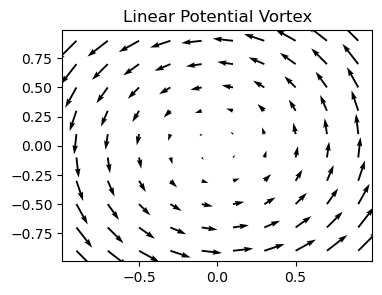

In [9]:
# Visualize linear potential vortex training data
_ = plot_flow_field(x_grid_train_linear, y_grid_train_linear, u_grid_train_linear, v_grid_train_linear, "Linear Potential Vortex")

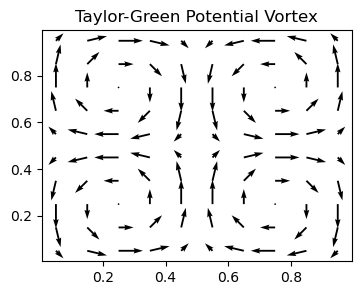

In [10]:
# Visualize linear Taylor-Green potential vortex training data
_ = plot_flow_field(x_grid_train_tg, y_grid_train_tg, u_grid_train_tg, v_grid_train_tg, "Taylor-Green Potential Vortex")

### Define Architecture

In [11]:
def my_nn_model() -> torch.nn.Module:
    """3 hidden layers of 32 nodes each"""
    model = torch.nn.Sequential(
        torch.nn.Linear(2, 32),
        torch.nn.ReLU(),  # <-- HYPERPARAMETER
        torch.nn.Linear(32, 32),
        torch.nn.ReLU(),  # <-- HYPERPARAMETER
        torch.nn.Linear(32, 32),
        torch.nn.ReLU(),  # <-- HYPERPARAMETER
        torch.nn.Linear(32, 2),
    )
    return model

### Define Loss Functions

Data error:
$$ E(x_i, y_i) = \left(\hat{u}_i - u\right) + \left(\hat{v}_i - v_i\right) $$

Physics error:
$$ E_\text{phys}(x_i, y_i) = \frac{\partial \hat{u}_i}{\partial x} + \frac{\partial \hat{v}_i}{\partial y} $$

In [12]:
physics_weight = 0.5  # <-- HYPERPARAMETER
loss_func = torch.nn.MSELoss()  # <-- HYPERPARAMETER

### Train

In [13]:
# Initialize training
linear_model = my_nn_model().to(DEVICE)
tg_model = my_nn_model().to(DEVICE)
num_epochs = 10000  # <-- HYPERPARAMETER

linear_train_loss_hist = []
tg_train_loss_hist = []
for model, train_loss_hist, data_loader in zip(
    [linear_model, tg_model],
    [linear_train_loss_hist, tg_train_loss_hist],
    [linear_train_loader, tg_train_loader],
):
    optimizer = torch.optim.SGD(model.parameters(), lr=0.05)  # <-- HPYERPARAMETER

    # Train
    for idx_epoch in trange(num_epochs):
        # Set model state to "training"
        model.train()
        train_loss = 0.0

        # Iterate over batches
        for x_grid, y_grid, u_grid, v_grid in data_loader:
            # Load data
            x_grid = x_grid.to(DEVICE).float().requires_grad_(True)
            y_grid = y_grid.to(DEVICE).float().requires_grad_(True)
            u_grid = u_grid.to(DEVICE).float()
            v_grid = v_grid.to(DEVICE).float()

            # Clear gradients
            optimizer.zero_grad()

            # Predict
            uv_grid = torch.cat((x_grid.unsqueeze(-1), y_grid.unsqueeze(-1)), dim=-1)
            uv_prediction = model(uv_grid)
            u_grid_prediction = uv_prediction[:, :, 0]
            v_grid_prediction = uv_prediction[:, :, 1]

            # Compute data loss
            u_loss = loss_func(u_grid_prediction, u_grid)
            v_loss = loss_func(v_grid_prediction, v_grid)
            u_loss.backward(retain_graph=True)
            v_loss.backward(retain_graph=True)

            # Compute physics loss
            dudx = torch.autograd.grad(
                u_grid_prediction,
                x_grid,
                grad_outputs=torch.ones_like(u_grid_prediction),
                create_graph=True
            )[0]
            dvdy = torch.autograd.grad(
                v_grid_prediction,
                y_grid,
                grad_outputs=torch.ones_like(v_grid_prediction),
                create_graph=True
            )[0]
            divergence = dudx + dvdy
            physics_loss = loss_func(divergence, torch.zeros_like(divergence))
            physics_loss.backward()

            # Compute total loss
            train_loss += u_loss.item() + v_loss.item() + physics_weight * physics_loss.item()
            optimizer.step()

        # Record iteration
        train_loss_hist.append(train_loss / len(data_loader))

100%|██████████| 10000/10000 [00:18<00:00, 539.41it/s]


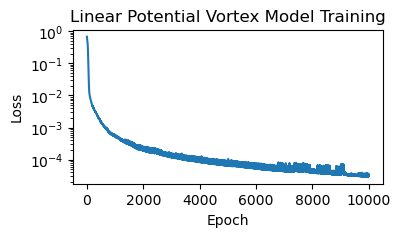

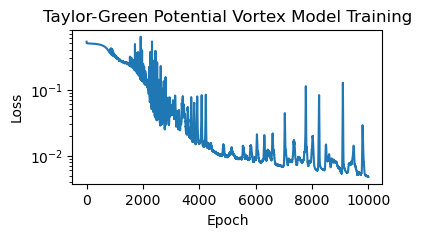

In [14]:
# Plot training trajectory
for train_loss_hist, title in zip(
    [
        linear_train_loss_hist,
        tg_train_loss_hist,
    ],
    [
        "Linear Potential Vortex Model Training",
        "Taylor-Green Potential Vortex Model Training",
    ],
):
    fig, ax = plt.subplots(figsize=(4, 2))
    ax.semilogy(train_loss_hist)
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    ax.set_title(title)

### Test

In [15]:
# Initialize testing
linear_test_loss = [0.0]  # convert from float to list to force pass-by-reference
linear_data_loss = [0.0]
tg_test_loss = [0.0]
tg_data_loss = [0.0]
for model, test_loss, data_loss, data_loader in zip(
    [linear_model, tg_model],
    [linear_test_loss, tg_test_loss],
    [linear_data_loss, tg_data_loss],
    [linear_test_loader, tg_test_loader],
):
    # Set model state to "evaluation"
    model.eval()

    # Test
    for x_grid, y_grid, u_grid, v_grid in data_loader:
        # Load data
        x_grid = x_grid.to(DEVICE).float().requires_grad_(True)
        y_grid = y_grid.to(DEVICE).float().requires_grad_(True)
        u_grid = u_grid.to(DEVICE).float()
        v_grid = v_grid.to(DEVICE).float()

        # Clear gradients
        optimizer.zero_grad()

        # Predict
        xy_grid = torch.cat((x_grid.unsqueeze(-1), y_grid.unsqueeze(-1)), dim=-1)
        uv_prediction = model(xy_grid)
        u_grid_prediction = uv_prediction[:, :, 0]
        v_grid_prediction = uv_prediction[:, :, 1]

        # Compute data loss
        u_loss = loss_func(u_grid_prediction, u_grid)
        v_loss = loss_func(v_grid_prediction, v_grid)
        u_loss.backward(retain_graph=True)
        v_loss.backward(retain_graph=True)

        # Compute physics loss
        dudx = torch.autograd.grad(
            u_grid_prediction,
            x_grid,
            grad_outputs=torch.ones_like(u_grid_prediction),
            create_graph=True
        )[0]
        dvdy = torch.autograd.grad(
            v_grid_prediction,
            y_grid,
            grad_outputs=torch.ones_like(v_grid_prediction),
            create_graph=True
        )[0]
        divergence = dudx + dvdy
        physics_loss = loss_func(divergence, torch.zeros_like(divergence))

        # Compute total loss
        test_loss[0] += u_loss.item() + v_loss.item() + physics_weight * physics_loss.item()
        data_loss[0] +=u_loss.item() + v_loss.item()

linear_test_loss = linear_test_loss[0]
linear_data_loss = linear_data_loss[0]
tg_test_loss = tg_test_loss[0]
tg_data_loss = tg_data_loss[0]

print(f"Linear Potential Vortex Model Test Loss: {linear_test_loss:.3e}")
print(f"Linear Potential Vortex Model Data Loss: {linear_data_loss:.3e}")
print(f"Taylor-Green Potential Vortex Model Test Loss: {tg_test_loss:.3e}")
print(f"Taylor-Green Potential Vortex Model Data Loss: {tg_data_loss:.3e}")

Linear Potential Vortex Model Test Loss: 1.362e-04
Linear Potential Vortex Model Data Loss: 6.478e-05
Taylor-Green Potential Vortex Model Test Loss: 1.165e+00
Taylor-Green Potential Vortex Model Data Loss: 1.164e+00


### Linear Interpolation Benchmark

In [16]:
class InterpUV():
    """Vector-valued 2-D interpolator"""
    def __init__(self, x_vec, y_vec, u_grid, v_grid):

        self.u_interp = RegularGridInterpolator([x_vec.T, y_vec.T], u_grid.T, bounds_error=False, fill_value=None)
        self.v_interp = RegularGridInterpolator([x_vec.T, y_vec.T], v_grid.T, bounds_error=False, fill_value=None)

    def __call__(self, x, y):
        u = self.u_interp((x, y))
        v = self.v_interp((x, y))
        return u, v

In [17]:
# Interpolate linear potential vortex
interp_linear = InterpUV(x_vec_train_linear, y_vec_train_linear, u_grid_train_linear, v_grid_train_linear)
u_test_interp_linear, v_test_interp_linear = interp_linear(x_grid_test_linear, y_grid_test_linear)

# Interpolate Taylor-Green potential vortex
interp_tg = InterpUV(x_vec_train_tg, y_vec_train_tg, u_grid_train_tg, v_grid_train_tg)
u_test_interp_tg, v_test_interp_tg = interp_tg(x_grid_test_tg, y_grid_test_tg)

In [18]:
# Loss of linear potential vortex interpolation
u_loss_interp_linear = loss_func(torch.from_numpy(u_test_interp_linear), u_test_tensor_linear)
v_loss_interp_linear = loss_func(torch.from_numpy(v_test_interp_linear), v_test_tensor_linear)
data_loss_interp_linear = u_loss_interp_linear + v_loss_interp_linear

# Loss of Taylor-Green potential vortex interpolation
u_loss_interp_tg = loss_func(torch.from_numpy(u_test_interp_tg), u_test_tensor_tg)
v_loss_interp_tg = loss_func(torch.from_numpy(v_test_interp_tg), v_test_tensor_tg)
data_loss_interp_tg = u_loss_interp_tg + v_loss_interp_tg

print(f"Linear Potential Vortex Interpolation Data Loss: {data_loss_interp_linear:.3e}")
print(f"Taylor-Green Potential Vortex Interpolation Data Loss: {data_loss_interp_tg:.3e}")

Linear Potential Vortex Interpolation Data Loss: 4.545e-33
Taylor-Green Potential Vortex Interpolation Data Loss: 1.123e+00


### Visualize Result

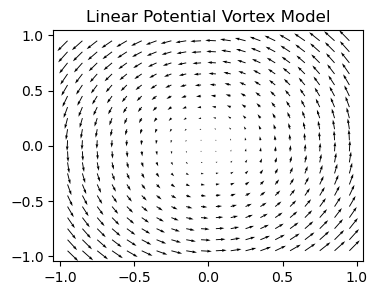

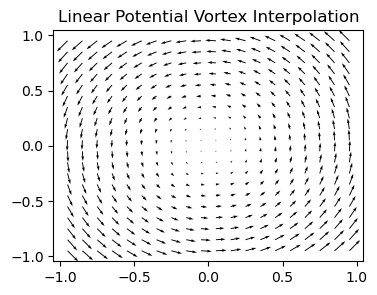

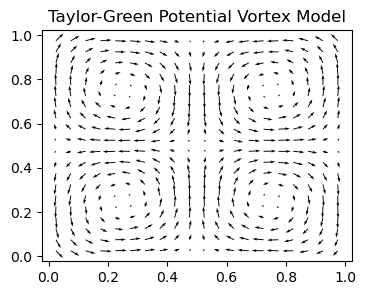

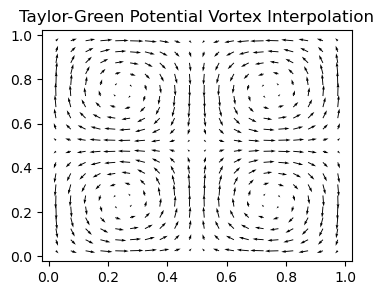

In [19]:
# Linear potential vortex
xlim = (-0.95, 0.95)
ylim = (-0.95, 0.95)
nx = 20
ny = 20
N_train_linear = nx * ny
_x = np.linspace(*xlim, nx)
_y = np.linspace(*ylim, ny)
x, y = np.meshgrid(_x, _y)
xy_grid = torch.cat(
    (torch.from_numpy(x).float().unsqueeze(-1), torch.from_numpy(y).float().unsqueeze(-1)),
    dim=-1,
)
uv = linear_model(xy_grid)
u = uv[:, :, 0].detach().numpy()
v = uv[:, :, 1].detach().numpy()
_ = plot_flow_field(x, y, u, v, "Linear Potential Vortex Model")
plt.savefig("fig2b_linear_model.pdf")
_ = plot_flow_field(x, y, *interp_linear(x, y), "Linear Potential Vortex Interpolation")
plt.savefig("fig2b_linear_interp.pdf")

# Taylor-Green potential vortex
xlim = (0.025, 0.975)
ylim = (0.025, 0.975)
nx = 20
ny = 20
N_train_linear = nx * ny
_x = np.linspace(*xlim, nx)
_y = np.linspace(*ylim, ny)
x, y = np.meshgrid(_x, _y)
xy_grid = torch.cat(
    (torch.from_numpy(x).float().unsqueeze(-1), torch.from_numpy(y).float().unsqueeze(-1)),
    dim=-1,
)
uv = tg_model(xy_grid)
u = uv[:, :, 0].detach().numpy()
v = uv[:, :, 1].detach().numpy()
_ = plot_flow_field(x, y, u, v, "Taylor-Green Potential Vortex Model")
plt.savefig("fig2b_tg_model.pdf")
_ = plot_flow_field(x, y, *interp_tg(x, y), "Taylor-Green Potential Vortex Interpolation")
plt.savefig("fig2b_tg_interp.pdf")